## Data Cleaning With Pandas and Scikit-learn
### Topics
General Data Cleaning Process 
+ 1. Data Loading
    + Normalize Data Types 
    + Basic Statistics On Data 
    + Column Selection
    + Label Create if applicible 
+ 2. Data Splitting
    + Where rows are indpepdened use random hold out
    + Cross validation may also be use, but always test against a final random hold out
+ 2. Remove Bad Data from TrainingSet, and Outliers (depending on the method)
    + sometimes 9999, or -1 can stand for Null.
    + if a linear type model, or a neural net is going to use, remove outliers from the training set 
    + discretizing variablies can also be a good strategy for dealing with outliers
+ 3. Handle Null Values
    + option 1. impute (replace null values with column means, constants or something similar
    + option 2. remote (drop either rows or columns with null values
        + Droping rows has major effects on test metrics, do so carifully
        + imputation will probably still be nessicary to ensure the model works on real world data 
+ 4. Encode Categorical Varaibles
+ 5. Discretized Location Varibles
        + Typicall with lat and lon inputs, discretizing the using Kmeans into ether one hot encoded or ordinal data
+ 6. Setup Feature Extraction Pipeline
+ 7. Extract Features
   + Extact Training and Test features 
+ 8. Features Selection (optional)
    + definetely use for linear or neural network models
    + may make no difference in Tree based models

#### Results  

At the end of this you should end up with the following

+ X_train numpy array of training data 
+ y_train numpy array of training outcomes 
+ X_test numpy array of test data
+ y_test numpy array of test outcomes 
+ feature_names: list of feature names 


##### Bonus
Creating a Decision tree and integrating it into the prediction pipeline

#### Data Set 
The objective of this project is to predict prices of AirBnB listing in NewYork City
The data is sources from Kaggle
+ https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data/version/3
+ download and unzip into directory where the jupyter notebook is launched

####  Data Loading 
+ data.dtypes is used to print out all the column types
    + object cols are essentially treated as categorical data
    
+ here the data by default loads 'last_review' as an object dtype, when it is actually a datetime.  This is corrected

In [61]:
from itertools import chain
from collections import Counter
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline 

In [62]:
# load in data 
path = 'AB_NYC_2019.csv'
# make last review an actual date col
data = pd.read_csv(path)
# changes last_review to a datetime column type
data['last_review'] = pd.to_datetime(data['last_review'], infer_datetime_format=True)

print(data.dtypes)
data.head(2)

id                                         int64
name                                      object
host_id                                    int64
host_name                                 object
neighbourhood_group                       object
neighbourhood                             object
latitude                                 float64
longitude                                float64
room_type                                 object
price                                      int64
minimum_nights                             int64
number_of_reviews                          int64
last_review                       datetime64[ns]
reviews_per_month                        float64
calculated_host_listings_count             int64
availability_365                           int64
dtype: object


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355


##### Basic Statistics
This revials the id and host_id columns are basically going to be useless since they are id cols, also there are
some serious outliers in reviews per month, and minium nights

In [63]:
# count rows
n_rows = data.count()
print('rows, columns {}'.format(data.shape))
data.describe().loc[['min', 'mean', 'max']]

rows, columns (48895, 16)


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
min,2.539000e+03,2.438000e+03,40.499790,-74.24442,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.95217,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
max,3.648724e+07,2.743213e+08,40.913060,-73.71299,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [64]:
# niegbor hood has very high dimmension and should probably be ignored 
n = len(Counter(data['neighbourhood'])) 
print('num unique neighbourhoods', n)

num unique neighbourhoods 221


##### Column Selection
+ select numeric columns, 
+ ignore ID Cols
+ Select categorical Columns with to high of dimension ( we choose neighboorhood_group rather than neighboorhood)

In [65]:
num_cols = ['minimum_nights', 
            'reviews_per_month', 
            'calculated_host_listings_count', 
            'availability_365']

cat_cols = ['room_type', 'neighbourhood_group']

text_cols = ['name']

lat_lon_cols = ['longitude',  'latitude']

##### Label Creation
+ in this case we are predicting whether a listing as price is likely to be in the top 25% percentile (more expensive than 75% of all the other listings
+ we add a label col to the data frame to train against

In [66]:
# calculated the threshold
threshold = np.percentile(data['price'], 75)
print('top 25% threshold {}'.format(threshold))

# defines a function for labeling
def labler(x, val):
    if x > val:
        return 1
    else:
        return 0
    
# set a label col variable
label_col = 'label'

# creates the new 'label' column
data[label_col] = list(map(lambda x:labler(x, threshold), data['price']))

# shows that label col is assigned correctly
data.loc[data[label_col] == 1][['label', 'price']].head(2)


top 25% threshold 175.0


,label,price
1,1,225
5,1,200


#### Data Splitting training and test sets
+ usees random hold out based on leaving 25% of the data back for training
+ works if rows are indpendent, 

In [67]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(data, test_size=0.25, random_state=42)
print('trainset shape {}'.format(df_train.shape))
print('testset shape {}'.format(df_test.shape))

trainset shape (36671, 17)
testset shape (12224, 17)


#### Remove Outliers from the train data set 
+ In this case some outliers are going to be remove for the purpose of demostration
+ Max Value threshold are use to remove rows in the training data only
    + minimun nights less more than 10 are removed
    + num reviews < 10 removed 

##### Bad Data
+ listings without 14 days of availibity are going to be consided bad data and also removed, since that appears to be very in frequent

In [68]:
df_train= df_train[(df_train['minimum_nights'] < 10) | 
                               (df_train['number_of_reviews'] < 10) | 
                               (df_train['availability_365'] > 14) ]
print('training shape after filtering: {0}'.format(df_train.shape))

training shape after filtering: (36472, 17)


#### Stratget on Data Preprocessing and Cleaning
The strategy to prepare the data for machine learning is a follows

+ create sklearn pipeline for different column types
+ fit indvidual pipeline 
+ assemble together into one final feature extraction pipeline
+ transform trainging and test sets
+ build a model, and add it on the end of the feature extaction pipeline

Sklearn pipelines are fundimentally a sequence of steps, each one returning an array or data frame conducted in order.

The steps are tuples of the type ('name', transformer) and a list of tuples provides the steps arg to Pipeline

#### Numeric Imputer to Handle Null Values
Null values in the X side of the equation are going to filled using a imputer, will precalucated column means
+ Create an imputer for later use
+ fit the imputer
+ packagbe the imputer in a pipeline

In [69]:
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median'))])
numeric_transformer = numeric_transformer.fit(data[num_cols])

#### Categorical Encoding 
In this case the unique values inside categorical columns are one hot encodied 1 if present, else 0
This  create an array of 0s and 1s, always with the same columns (found during the fit phase)
+ create an imputer to fill missing values with 'missing'
+ Creat the encoder, package into a pipeline
+ fit on training data 
+ extract out the categorical names 

By default One hot encoding returns a scipy sparse array.  Typically this has no problem with later methods, but can be converted to a dense numpy array using the .todense() method 

In [70]:
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder( handle_unknown='ignore'))])
       
categorical_transformer = categorical_transformer.fit(data[cat_cols])

# extract categorical feature names , this returns a list of list
cat_feature_names = categorical_transformer.steps[-1][1].categories_

# chain flattens the list of list into one list
cat_feature_names = list(chain.from_iterable(cat_feature_names ))

print('original data:')
print(data[cat_cols].head(2), '\n')
print('Transformed One Hot Encoded data: ')
pd.DataFrame(categorical_transformer.transform(data[cat_cols].head(2)).todense(), columns= cat_feature_names)



original data:
         room_type neighbourhood_group
0     Private room            Brooklyn
1  Entire home/apt           Manhattan 

Transformed One Hot Encoded data: 


,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Discretizing Lat and Lon Location Data  using Kmeans
This process will essentually bin the lat and long data into categories and automatically one hot encode them
But first look to see what the data looks like .
+ setup an imputer 
+ Center and scale the data  (give it mean zero, sd 1)
+ create kmean model to cluster the data lat lon data 
+ package in a pipeline and fit
+ plot results

The results of this pipeline is a numpy array with distances between the row and each centers.
THe final array has n_centers = n_columns

In [71]:
# define the number of clusters to use (number of centers )
n_centers = 5

# init the scaler normalizes values
scaler = StandardScaler()

# int the kmeans model
binner = KMeans(n_clusters=n_centers)

# package in a pipeline
lat_lon_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='mean')),
                                      ('scaling', scaler), 
                                      ('binning and ohe', binner)])
lat_lon_transformer.fit(df_train[lat_lon_cols])

# this test thje transform and gets a bin number for each row, to plot
bins = np.argmin(lat_lon_transformer.transform(df_train[lat_lon_cols]), axis=1)

#example output form the lat lon transformer 
lat_lon_feature_names = list(range(lat_lon_transformer.steps[-1][1].n_clusters))
lat_lon_feature_names = ['Distance to loc:' + str(v) for v in lat_lon_feature_names]

# show an example of the transformation
pd.DataFrame(lat_lon_transformer.transform(df_train[lat_lon_cols].head(2)), columns=lat_lon_feature_names)


,Distance to loc:0,Distance to loc:1,Distance to loc:2,Distance to loc:3,Distance to loc:4
0,0.774815,0.511768,1.223605,2.229416,3.051302
1,4.711754,4.032252,5.384884,5.288705,2.322370


In [72]:
# gets the cluster centers
cluster_centers = lat_lon_transformer.steps[-1][1].cluster_centers_

# inverses the scaler, so our centers are back on lon, lat scale
cluster_centers = lat_lon_transformer.steps[-2][1].inverse_transform(cluster_centers)
cluster_centers


array([[-73.98291724,  40.65737101],
       [-73.9355794 ,  40.69904393],
       [-73.98744046,  40.7402404 ],
       [-73.93834936,  40.80468322],
       [-73.8168756 ,  40.70859952]])

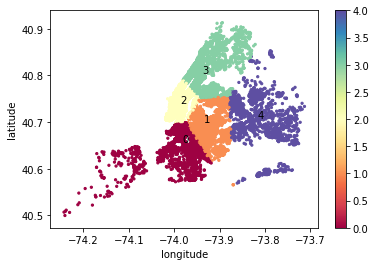

In [73]:
# importas a color map from maplot lib
cmap = cm.get_cmap('Spectral')

# creates a scatter plot with bin number as coloring
df_train.plot.scatter(*lat_lon_cols, c=bins, cmap=cmap, s=5)
#plots the centers
for i in range(cluster_centers.shape[0]):
    plt.text(cluster_centers[i,0], cluster_centers[i,1], str(i))
plt.show()


#### Putting all the Pipelines Together,
Sklearn Column transformer is used to piece together the three pipelines and get them to act as one system.
+ Column transformer acts like a router, and ensures that each column goes to the correct transformer
+ takes a list of tuples (step name, pipeline, col_list)

In [74]:
# setup the Column transformer to act as a router, routing numeric columns to numeric transformer ect
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, num_cols),
                                               ('cat', categorical_transformer, cat_cols),
                                               ('location', lat_lon_transformer, lat_lon_cols)])          
   
# Put it all togeth in one pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor)])
pipe = pipe.fit(df_train)


# extractiong out features names
feature_names = num_cols + cat_feature_names + lat_lon_feature_names
print('n_features:', len(feature_names))
print(feature_names)

n_features: 17
['minimum_nights', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'Entire home/apt', 'Private room', 'Shared room', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island', 'Distance to loc:0', 'Distance to loc:1', 'Distance to loc:2', 'Distance to loc:3', 'Distance to loc:4']


#### Transform Training and Test Data 
+ a quick sanity check is that the number of feature_names matches the numnber of columns on after transformation
+ Now we have all the elements need for training a model
    + X_train: array in traininig features
    + y_train: array of training outcomes, same num rows as X_train
    + X_test: array of test feature, same num cols  as X_train
    + y_test:  np.array of test outcomes, with same number of rows as X_test 
    + feature_names: list of feature names, same length as num cols in X_train



In [75]:
# create training arrays
X_train = pipe.transform(df_train)
y_train = df_train[label_col].values

# create test arrays 
X_test = pipe.transform(df_test)
y_test = df_test[label_col].values

print('train shape:', X_train.shape, 'test shape:', X_test.shape)
pd.DataFrame(X_train[:2,:], columns=feature_names)


train shape: (36472, 17) test shape: (12224, 17)


,minimum_nights,reviews_per_month,calculated_host_listings_count,availability_365,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Distance to loc:0,Distance to loc:1,Distance to loc:2,Distance to loc:3,Distance to loc:4
0,3.0,2.18,1.0,304.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.781120,1.222993,3.049961,2.229082,0.508483
1,30.0,0.04,43.0,354.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.716242,5.384150,2.323596,5.288331,4.032485


#### Basic Model Training
Since this project is so close, why not take it to the end a create a model
Basic Decision Tree Classifier is create to predict new instances

In [76]:
# instantiates the model
model = DecisionTreeClassifier(max_leaf_nodes=3, random_state=0)

# Fits the model on training data
model = model.fit(X_train, y_train)

# predicts probablities for the test data
pred_test = model.predict_proba(X_test)[:, 1]

# predicts labels for the test data
pred_labels_test =  model.predict(X_test)


##### Error Metrics on the Model
As will any classification model, we should look at error metrics 


In [77]:
from sklearn.metrics import roc_auc_score,  classification_report, confusion_matrix

# roc Auc score 
test_auc = roc_auc_score(y_test, pred_test)
print('test AUC {}'.format(test_auc))

# classifcation Report 
report = classification_report(y_test, pred_labels_test)
print(report)

# confusion Matrix
cm = confusion_matrix(y_test, pred_labels_test)

print('TN, FP \n FN TP')
print(cm)

test AUC 0.8219778140450534
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      9213
           1       0.64      0.58      0.61      3011

    accuracy                           0.82     12224
   macro avg       0.76      0.74      0.75     12224
weighted avg       0.81      0.82      0.81     12224

TN, FP 
 FN TP
[[8250  963]
 [1270 1741]]


#### Vizualizing The Model
Here we can plot the model directly using graphviz, note graphvis need to be in the path for this to work
for more information look at 

https://www.enterprise-architecture.org/downloads?id=208

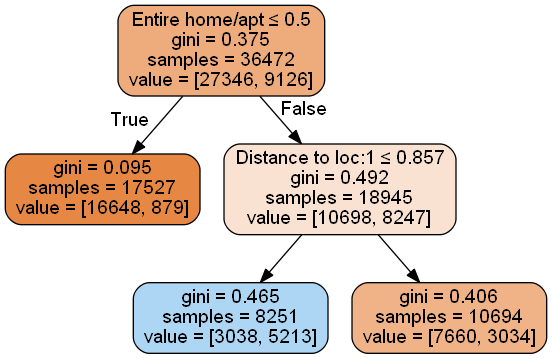

In [78]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(model, out_file=dot_data,  
                filled=True, rounded=True,
                feature_names = feature_names, 
                special_characters=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Setup a Prection Pipeline 
Just to complete the project, add the model on onto the steps of the Pipeline to combine feature extraction and data cleaning with predticion methods


In [79]:
steps = pipe.steps + [('model', model)]
prediction_pipe= Pipeline(steps =steps)

output_cols = ['bottom75', 'top25']
pd.DataFrame(prediction_pipe.predict_proba(data.head()), columns =output_cols)

,bottom75,top25
0,0.949849,0.050151
1,0.368198,0.631802
2,0.949849,0.050151
3,0.716290,0.283710
4,0.716290,0.283710


##### Next Steps:

We ignored the text data! this may be usefull, but for the purposes of pipeline, there are a few bugs to work out with sklearns count vectorizor

+ Parameter Tuning - try different parameters 
    + try different parameters for the models, and preprocessing transformations
    + use GridSearchCV to brute force through parameter grids
+ Feature Selection 
    + use information gain to remote unused features 
+ Missclassification Analysis
    + find examples of aggregous mistages by the model, and investige
+ Cost Opitmization
    + establish exactly where the probablity cut off should be
+ Deploy to Production Environment
    
    
    
    
    


